# Analysis #1: Genome and transcriptome quality and relationship to osk discovery
- Author: Savandara BESSE
- Creation: 05-22-2017
- Last modification : 09-04-2019

### Required inputs
- ./Data/02_Oskar_analyses/2.1/TSA_OSK_TABLE.csv
- ./Data/02_Oskar_analyses/2.1/GENOME_OSK_TABLE.csv

### Description
Generates plots for figure S1. Compares the two distributions for each of the 8 available assembly statistics: Contig and Scaffold N50, Contig and Scaffold L50, contig and Scaffold counts and Number of Contig and Scaffold per genome length.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree
import matplotlib.patches as mpatches
import decimal, scipy, json, os, progressbar, re, time
from Bio import Entrez
from tqdm import tqdm_notebook as tqdm

Entrez.email = 'your@email.here' #Use your own email
data_path = '../Data/02_Oskar_analyses'
%matplotlib inline

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy c-extensions failed.
- Try uninstalling and reinstalling numpy.
- If you have already done that, then:
  1. Check that you expected to use Python3.7 from "/Users/xqua/opt/anaconda3/envs/datascience/bin/python",
     and that you have no directories in your PATH or PYTHONPATH that can
     interfere with the Python and numpy version "1.17.3" you're trying to use.
  2. If (1) looks fine, you can open a new issue at
     https://github.com/numpy/numpy/issues.  Please include details on:
     - how you installed Python
     - how you installed numpy
     - your operating system
     - whether or not you have multiple versions of Python installed
     - if you built from source, your compiler versions and ideally a build log

- If you're working with a numpy git repository, try `git clean -xdf`
  (removes all files not under version control) and rebuild numpy.

Note: this error has many possible causes, so please don't comment on
an existing issue about this - open a new one instead.

Original error was: dlopen(/Users/xqua/opt/anaconda3/envs/datascience/lib/python3.7/site-packages/numpy/core/_multiarray_umath.cpython-37m-darwin.so, 2): Library not loaded: @rpath/libquadmath.0.dylib
  Referenced from: /Users/xqua/opt/anaconda3/envs/datascience/lib/libgfortran.4.dylib
  Reason: image not found


## STEP 1: Create Genome and Transcriptome statistic tables

In [ ]:
def formatID(x):
    return x.replace('01','')

def repno(x):
    try:
        d = int(x)
    except:
        d = np.nan
    return d

def remzero(x):
    if x == 0:
        return np.nan
    else:
        return x
    
def annotyesno(x):
    if x == 'Yes':
        return 1
    else:
        return 0
    
def contigcountno(x):
    if x  == 'TSA':
        return 0
    lambda x : True if (x > 10 and x < 20) else False

In [ ]:
def build_TSA_dataframe(search_results, tsa_metadata):
    '''
    Add results of oskar analysis in transcriptome dataframe 
    Merge them with metadata collected from TSA database
    '''
    search_results['oskar'] = search_results[search_results['source'] == 'TSA']['filtered_hits'].apply(lambda x: 'found' if (x > 0) else 'not found' )
    TSA_oskar_results = search_results[search_results['source'] == 'TSA']
    TSA_oskar_results['prefix_s'] = TSA_oskar_results['id'].apply(lambda x: x[:4] + '0' + x[-1])
    TSA_dataframe = TSA_oskar_results.merge(tsa_metadata, on='prefix_s')
    return TSA_dataframe[['id', 'species', 'family_name', 'order_name', 'hits', 'filtered_hits', 'oskar', 'prefix_s', 'project_s', 'bioproject_s', 'biosample_ss', 'contigs_total_length_l', 'contigs_count_l']]

def build_genome_dataframe(genome_database, search_results):
    '''
    Add results of oskar analysis in genome dataframe 
    Collect specific variables for genome statistics from NCBI database
    '''
    genome_oskar = []
    genome_ids = genome_database['genome_id'].unique()
    oskars_ids = search_results[search_results['filtered_hits'] > 0]['id'].unique()
    for genome_id in tqdm(genome_ids) :
        time.sleep(0.5)
        genome_search = Entrez.esearch(db="assembly", term=genome_id)
        orgn_id = Entrez.read(genome_search)['IdList']
        assembly_handle = Entrez.esummary(db="assembly", id=orgn_id)
        summary = Entrez.read(assembly_handle, validate=False)['DocumentSummarySet']['DocumentSummary']

        for tag in summary :

            alt_loci_count = re.findall(r'<Stat category="alt_loci_count" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            chromosome_count = re.findall(r'<Stat category="chromosome_count" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            contig_count = re.findall(r'<Stat category="contig_count" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            contig_l50 = re.findall(r'<Stat category="contig_l50" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            contig_n50 = re.findall(r'<Stat category="contig_n50" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            non_chromosome_replicon_count = re.findall(r'<Stat category="non_chromosome_replicon_count" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            scaffold_count = re.findall(r'<Stat category="scaffold_count" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            scaffold_l50 = re.findall(r'<Stat category="scaffold_l50" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            scaffold_n50 = re.findall(r'<Stat category="scaffold_n50" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            total_length = re.findall(r'<Stat category="total_length" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]
            ungapped_length = re.findall(r'<Stat category="ungapped_length" sequence_tag="all">([0-9]+)<\/Stat>', tag['Meta'])[0]

        
        if genome_id in oskars_ids: 
            status = 'found'
        else:
            status = 'not found'
        genome_oskar.append([genome_id, status, int(alt_loci_count), int(chromosome_count), int(contig_count), int(contig_l50), int(contig_n50), int(non_chromosome_replicon_count), int(scaffold_count), int(scaffold_l50), int(scaffold_n50), int(total_length), int(ungapped_length)])
                                
    GENOME_dataframe = pd.DataFrame(genome_oskar, columns = ['id', 'oskar', 'alt_loci_count', 'chromosome_count', 'contig_count', 'contig_l50', 'contig_n50','non_chromosome_replicon_count', 'scaffold_count', 'scaffold_l50', 'scaffold_n50', 'total_length', 'ungapped_length'])
    GENOME_dataframe['contigNumberperLength'] = GENOME_dataframe['contig_count'] / GENOME_dataframe['total_length']
    GENOME_dataframe['scaffoldNumberperLength'] = GENOME_dataframe['scaffold_count'] / GENOME_dataframe['total_length']
    return GENOME_dataframe

#### Load metadata

In [ ]:
TSA_METADATA = pd.read_csv(os.path.join('../Data/01_Oskar_identification/2019/TSA_master_metadata.csv'))

In [ ]:
genome_database = pd.read_csv('../Data/01_Oskar_identification/2019/genome_insect_database.csv')

In [ ]:
search_results = pd.read_csv('../Data/01_Oskar_identification/oskar_tracker_results/search_results.csv')

#### _TSA OSK TABLE GENERATION (IF NOT PROVIDED)_

In [ ]:
TSA_DB = build_TSA_dataframe(search_results, TSA_METADATA)
TSA_DB.to_csv('../Data/02_Oskar_analyses/2.1/TSA_OSK_TABLE.csv')

#### _GENOME OSK TABLE GENERATION (IF NOT PROVIDED)_

In [ ]:
genome_dataframe = build_genome_dataframe(genome_database, search_results)
genome_dataframe.to_csv('../Data/02_Oskar_analyses/2.1/GENOME_OSK_TABLE.csv')

## /!\ Run from here directly if TSA_OSK_TABLE.csv and GENOME_OSK_TABLE.CSV provided

In [1]:
TSA_DF= pd.read_csv(os.path.join(data_path,'2.1/TSA_OSK_TABLE.csv'))
GENOME_DF = pd.read_csv(os.path.join(data_path, '2.1/GENOME_OSK_TABLE.csv'))

### Palette color definition for plots

sns.set(style="whitegrid", palette="muted")
muted    = ["#999999", "#cccccc"]
newPal   = {
            'found': muted[0],  
            'not found':muted[1]
           }

NameError: name 'pd' is not defined

## STEP 2: Statistics on transcriptome data

### 2.1 Total length of contigs for transcriptome data

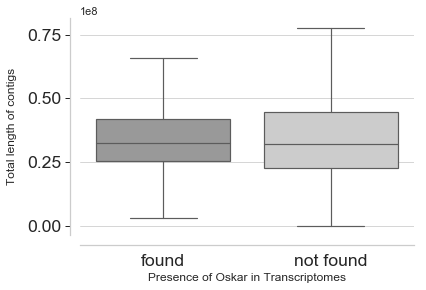

MannwhitneyuResult(statistic=92996.0, pvalue=0.16467575711110483)

In [3]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)
sns.boxplot(data=TSA_DF, x='oskar', y='contigs_total_length_l', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.ylabel('Total length of contigs', labelpad=10)
plt.xlabel('Presence of Oskar in Transcriptomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/Contig_total_length_tsa.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/Contig_total_length_tsa.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=TSA_DF[TSA_DF['oskar'] == 'not found']['contigs_total_length_l'].values, y=TSA_DF[TSA_DF['oskar'] == 'found']['contigs_total_length_l'].values)

### 2.2 Contig count for transcriptomes

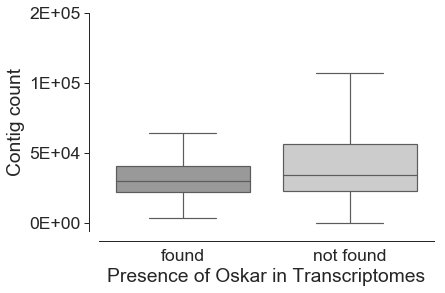

MannwhitneyuResult(statistic=85735.5, pvalue=0.003702719606840151)

In [4]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=TSA_DF, x='oskar', y='contigs_count_l', order=['found', 'not found'], showfliers=False,palette=newPal)
plt.yticks(np.arange(0, 2e5, step=0.5e5), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 2e5, step=0.5e5)])
plt.ylabel('Contig count')
plt.xlabel('Presence of Oskar in Transcriptomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/Contig_tsa.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/Contig_tsa.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=TSA_DF[TSA_DF['oskar'] == 'not found']['contigs_count_l'].values, y=TSA_DF[TSA_DF['oskar'] == 'found']['contigs_count_l'].values)

## STEP 3 : Statistics for genomes

### 3.1 Chromosome count for genomes

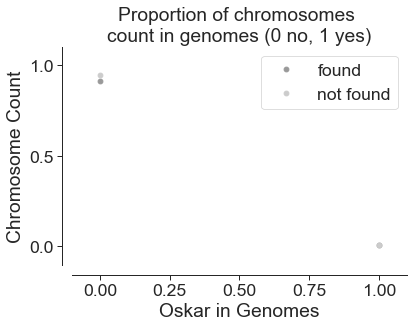

MannwhitneyuResult(statistic=22851.5, pvalue=0.10791952904902669)

In [5]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

f = GENOME_DF[GENOME_DF['oskar'] == 'found']['chromosome_count']
nf = GENOME_DF[GENOME_DF['oskar'] == 'not found']['chromosome_count']
x1, y1 = np.histogram(f)
x2, y2 = np.histogram(nf)
x1 = x1/x1.sum()
x2 = x2/x2.sum()
f = [x1[0], x1[-1]]
nf = [x2[0], x2[-1]]
plt.plot([0,1],f,'o',label='found',color=muted[0])
plt.plot([0,1],nf,'o',label='not found',color=muted[1])
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()

plt.title('Proportion of chromosomes \ncount in genomes (0 no, 1 yes)')
plt.ylabel('Chromosome Count')
plt.xlabel('Oskar in Genomes')

# fig.savefig('../Figures/SVG/chromosome_count_Genomes.svg', format='svg')
# fig.savefig('../Figures/PDF/chromosome_count_Genomes.pdf', format='pdf')
plt.show()

scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'not found']['chromosome_count'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'found']['chromosome_count'].values)

### 3.2 Contig count for genomes

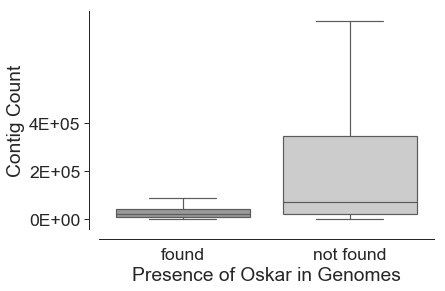

MannwhitneyuResult(statistic=13704.0, pvalue=4.9827321507429246e-14)

In [6]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='contig_count', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 6e5, step=2e5), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 6e5, step=2e5)])
plt.ylabel('Contig Count')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.B1.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.B1.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'not found']['contig_count'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'found']['contig_count'].values)

### 3.3 Contig l50 for genomes

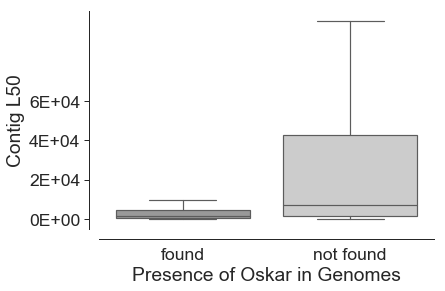

MannwhitneyuResult(statistic=12814.0, pvalue=2.467574180391434e-16)

In [7]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='contig_l50', showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 7e4, step=2e4), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 7e4, step=2e4)])
plt.ylabel('Contig L50')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.B2.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.B2.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'not found']['contig_l50'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'found']['contig_l50'].values)


### 3.4 Contig n50 for genomes

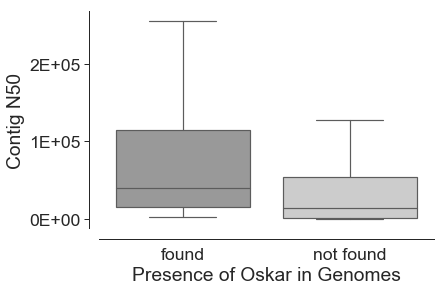

MannwhitneyuResult(statistic=14803.0, pvalue=1.8970907735355077e-11)

In [8]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='contig_n50', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 3e5, step=1e5), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 3e5, step=1e5)])
plt.ylabel('Contig N50')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.B3.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.B3.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'not found']['contig_n50'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'found']['contig_n50'].values)

### 3.5 Non chromosome replicon count in genomes

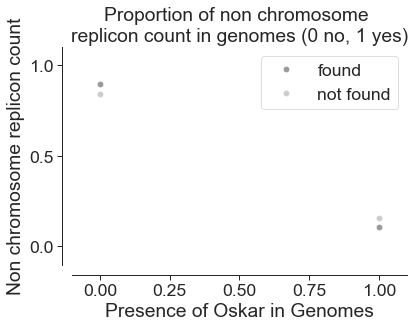

MannwhitneyuResult(statistic=22332.0, pvalue=0.05917424593226852)

In [9]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

f = GENOME_DF[GENOME_DF['oskar'] == 'found']['non_chromosome_replicon_count']
nf = GENOME_DF[GENOME_DF['oskar'] == 'not found']['non_chromosome_replicon_count']
x1, y1 = np.histogram(f)
x2, y2 = np.histogram(nf)
x1 = x1/x1.sum()
x2 = x2/x2.sum()
f = [x1[0], x1[-1]]
nf = [x2[0], x2[-1]]
plt.plot([0,1],f,'o',label='found',color=muted[0])
plt.plot([0,1],nf,'o',label='not found',color=muted[1])
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend()

plt.title('Proportion of non chromosome \nreplicon count in genomes (0 no, 1 yes)')
plt.ylabel('Non chromosome replicon count')
plt.xlabel('Presence of Oskar in Genomes')

# fig.savefig('../Figures/SVG/non_chromosome_replicon_count_Genomes.svg', format='svg')
# fig.savefig('../Figures/PDF/non_chromosome_replicon_count_Genomes.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['non_chromosome_replicon_count'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['non_chromosome_replicon_count'].values)

### 3.6 Scaffold count for genomes

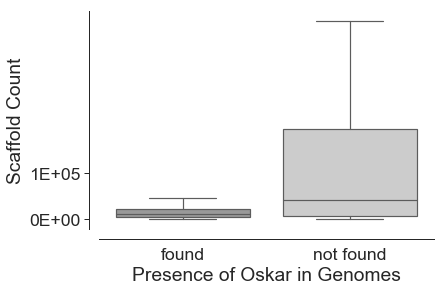

MannwhitneyuResult(statistic=14116.0, pvalue=5.003630981985501e-13)

In [10]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='scaffold_count', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 2e5, step=1e5), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 2e5, step=1e5)])
plt.ylabel('Scaffold Count')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.C1.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.C1.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['scaffold_count'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['scaffold_count'].values)

### 3.7 Scaffold l50 for genomes

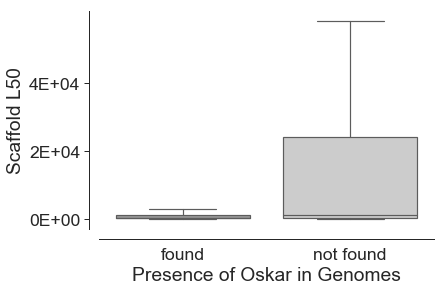

MannwhitneyuResult(statistic=14561.0, pvalue=5.429963764807342e-12)

In [11]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='scaffold_l50', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 6e4, step=2e4), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 6e4, step=2e4)])
plt.ylabel('Scaffold L50')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.C2.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.C2.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['scaffold_l50'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['scaffold_l50'].values)

### 3.8 Scaffold n50 in genomes

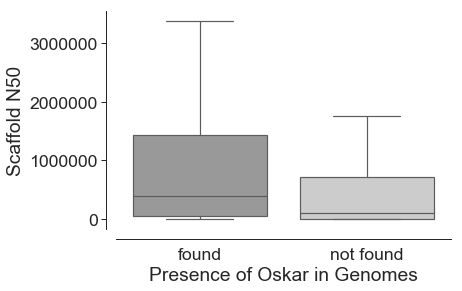

MannwhitneyuResult(statistic=16407.0, pvalue=3.30804504390163e-08)

In [12]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='scaffold_n50', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.ylabel('Scaffold N50')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.C3.svg', format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.C3.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['scaffold_n50'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['scaffold_n50'].values)

### 3.9 Total length for genomes

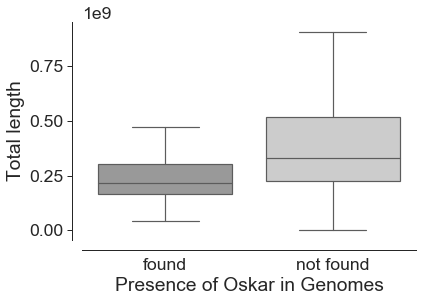

MannwhitneyuResult(statistic=14850.0, pvalue=2.4094399062682326e-11)

In [13]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='total_length', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.ylabel('Total length')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/SVG/total_length_Genomes.svg',format='svg')
# fig.savefig('../Figures/PDF/total_length_Genomes.pdf',format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['total_length'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['total_length'].values)

### 3.10 Ungapped length for genomes

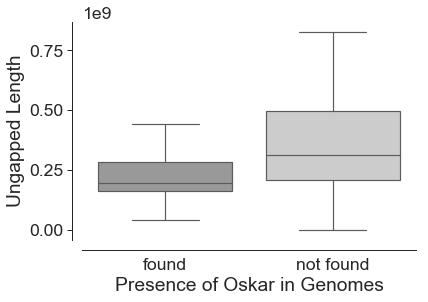

MannwhitneyuResult(statistic=14565.0, pvalue=5.5476129795166676e-12)

In [14]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='ungapped_length', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.ylabel('Ungapped Length')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/SVG/ungapped_length_Genomes.svg', format='svg')
# fig.savefig('../Figures/PDF/ungapped_length_Genomes.pdf', format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['ungapped_length'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['ungapped_length'].values)

### 3.11 Contig number per length for genomes

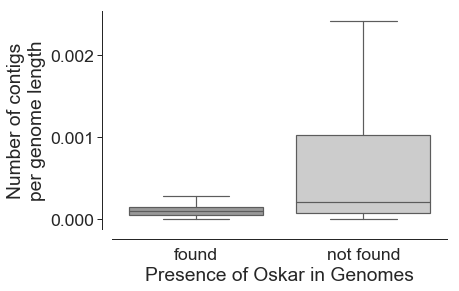

MannwhitneyuResult(statistic=15246.0, pvalue=1.7197506629887118e-10)

In [15]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='contigNumberperLength', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.ylabel('Number of contigs\nper genome length')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.B4.svg',format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.B4.pdf',format='pdf')
plt.show()

scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['contigNumberperLength'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['contigNumberperLength'].values)

### 3.12 Scaffold number per length for genomes

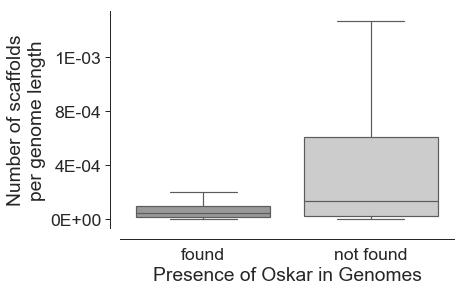

MannwhitneyuResult(statistic=15741.0, pvalue=1.7744611346932319e-09)

In [16]:
fig = plt.figure(figsize=(6,4))
plt.locator_params(axis='y', nbins=4)
sns.set_context("paper", font_scale=2)
sns.set_style("ticks")
sns.despine(offset=10)

sns.boxplot(data=GENOME_DF, x='oskar', y='scaffoldNumberperLength', order=['found', 'not found'], showfliers=False, palette=newPal)
plt.yticks(np.arange(0, 1.5e-3, step=0.0004), [ '%.E' % decimal.Decimal(i) for i in np.arange(0, 1.5e-3, step=0.0004)])
plt.ylabel('Number of scaffolds\nper genome length')
plt.xlabel('Presence of Oskar in Genomes')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True) 

# fig.savefig('../Figures/RAW/SVG/S1.C4.svg',format='svg')
# fig.savefig('../Figures/RAW/PDF/S1.C4.pdf',format='pdf')
plt.show()

### Mann-WhitneyU test
scipy.stats.mannwhitneyu(x=GENOME_DF[GENOME_DF['oskar'] == 'found']['scaffoldNumberperLength'].values, y=GENOME_DF[GENOME_DF['oskar'] == 'not found']['scaffoldNumberperLength'].values)